# RGI17 (Southern Andes)

F. Maussion & F. Roura Adserias

We were supposed to use the new Chile and argentina inventories. But because or problems in the Chile inventory and because of inconsistencies at the country border we can't do that. So we stick to RGI6 everywhere...

In [6]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 17

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '17_rgi60_SouthernAndes.zip')

# Support data dir
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [3]:
# Read L2 files from GLIMS
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, df_class = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
97,16,182.7,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
98,54,739.7,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
99,21,1015.9,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
100,25,862.0,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
101,13,1165.2,Rivera,Bown,2005,"Chilean glaciers, between -18 and -56 degrees ...",2001,2001,2001
478,1,6.2,Zenteno,Zenteno,2007,"Chilean glaciers, between -18 and -56 degrees ...",2005,2005,2005
510,7,63.3,Schnirch,Schneider,2008,Antarctic Peninsula,1998,1998,1998
511,8,15.4,Schnirch,Schneider,2008,Antarctic Peninsula,1998,1998,1998
512,12,86.8,Schnirch,Schneider,2008,Antarctic Peninsula,1998,1998,1998


Notes based on manual observations:
- 510 to 516 are a few outlines in Patagonia
- 592 is RGI, looks spatially complete.
- 700 is the Argentina glacier inventory. 708 is an update of 75 of its outlines, for reasons quite unclear to me (the outlines are still in 700)
- 730 is the Chilan glacier inventory

both 700/708 and 720 have the same issues (rock glaciers) as for RGI16. Furthermore, the Argentina / Chile border makes both inventories pretty much useless as is.

In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_sel_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_sel_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_sel_inventories']))

## Outline selection 

In [7]:
pata_icefield = shp.loc[shp.subm_id.isin([97, 98, 99, 100, 101])].copy()
rgi5 = shp.loc[shp.subm_id.isin([592])].copy()

In [8]:
# Area around the icefield
box = open_zip_shapefile(support_dir + '/rgi17_exclude_592.zip')

In [9]:
# Remove the icefield ids form rgi5
rp = rgi5.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi5.index
difference = gpd.overlay(rp, box, how='difference')
rgi5 = rgi5.loc[difference['orig_index']].copy()

In [10]:
# Size filter?
needs_size_filter(rgi5), needs_size_filter(pata_icefield)

(False, True)

In [11]:
print(len(pata_icefield))
pata_icefield = size_filter(pata_icefield)
print(len(pata_icefield))

129
109


In [12]:
rgi7 = pd.concat([rgi5, pata_icefield])
rgi7['is_rgi6'] = True

### Some sanity checks 

In [13]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA,N Outlet gl,N Moutain gl,N Valley gl
subm_id,,,,,
592,15800,15800,0,0,0
97,15,13,2,0,0
98,39,31,7,1,0
99,19,15,4,0,0
100,23,17,4,1,1
101,13,10,3,0,0


In [18]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area
        orphan_f = orphan_f.loc[orphan_f.subm_id.isin(rgi7.subm_id.unique()[check])]

Orphan rock outcrops detected in subm_id [592.  97.  98.  99. 100. 101.]


In [19]:
orphan_f['area'].sum() * 1e-6

0.2437626271356674

### Plots 

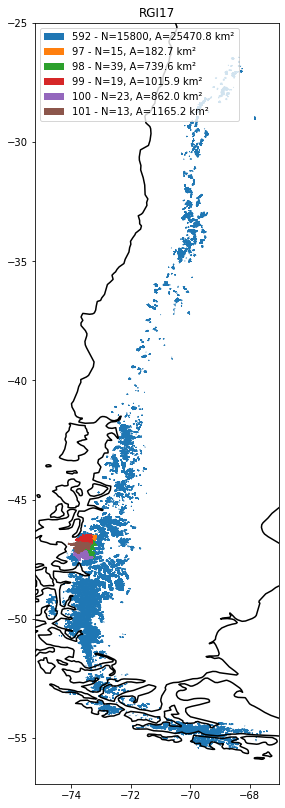

In [24]:
plot_map(rgi7, reg, aspect=0.8, loc='upper left')

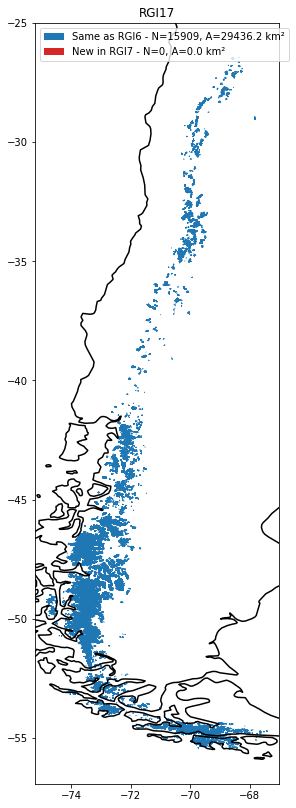

In [26]:
plot_map(rgi7, reg, aspect=0.8, loc='upper left', is_rgi6=True)

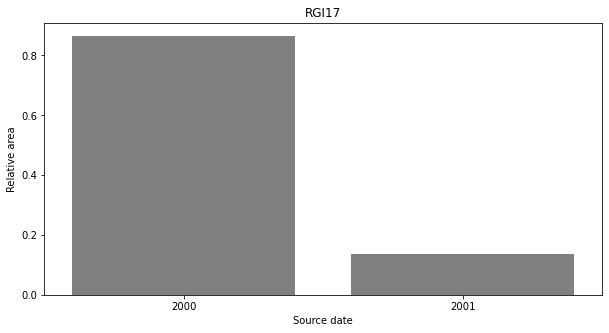

In [27]:
plot_date_hist(rgi7, reg)

### Text for github

In [28]:
fgh = sdf.T
fgh

subm_id,592,97,98,99,100,101
N,15800,15,39,19,23,13
A,25470.8,182.7,739.6,1015.9,862.0,1165.2
analysts,"De Angelis, Miles, Moelg, Paul, Sharp, Wyatt",Rivera,Rivera,Rivera,Rivera,Rivera
submitters,Cogley,Bown,Bown,Bown,Bown,Bown
release_date,2015,2005,2005,2005,2005,2005
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,"Chilean glaciers, between -18 and -56 degrees ...","Chilean glaciers, between -18 and -56 degrees ...","Chilean glaciers, between -18 and -56 degrees ...","Chilean glaciers, between -18 and -56 degrees ...","Chilean glaciers, between -18 and -56 degrees ..."
src_date_mode,2000,2001,2001,2001,2001,2001
src_date_min,2000,2001,2001,2001,2001,2001
src_date_max,2000,2001,2001,2001,2001,2001


In [29]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 592                                                                    | 97                                                     | 98                                                     | 99                                                     | 100                                                    | 101                                                    |
|:--------------|:-----------------------------------------------------------------------|:-------------------------------------------------------|:-------------------------------------------------------|:-------------------------------------------------------|:-------------------------------------------------------|:-------------------------------------------------------|
| N             | 15800                                                                  | 15                                                     | 39                                                     | 19                                         

## Write out and tar 

In [30]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI17.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI17'], returncode=0)


## Consistency check with RGI6 

In [83]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [84]:
len(rgi7), len(rgi6)

(15909, 15908)

Test the areas:

In [85]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 

In [86]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 29436.228868543338
Area RGI6 (km2) 29429.170810136457
diff areas RGI6 - RGI7 computed by us (km2) -7.058058406879424


In [87]:
# Remove the icefield ids form rgi5
rp = rgi6.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi6.index

difference = gpd.overlay(rp, box, how='difference')
rgi6_nopata = rgi6.loc[difference['orig_index']].copy()
difference = gpd.overlay(rp, box, how='intersection')
rgi6_pata = rgi6.loc[difference['orig_index']].copy()
assert len(rgi6_nopata) + len(rgi6_pata) == len(rgi6)

In [91]:
print(f'N1 = {len(pata_icefield)} , N2 = {len(rgi6_pata)}')
print('Area RGI7 pata (km2)', pata_icefield['area'].sum() * 1e-6)
print('Area RGI6 pata (km2)', rgi6_pata['area'].sum() * 1e-6)
print('diff', (rgi6_pata['area'].sum() - pata_icefield['area'].sum()) * 1e-6)

N1 = 109 , N2 = 111
Area RGI7 pata (km2) 3965.455814354333
Area RGI6 pata (km2) 3958.550138134954
diff -6.905676219378948


There are some small difference between RGI and what's in GLIMS. Let's just ignore them:

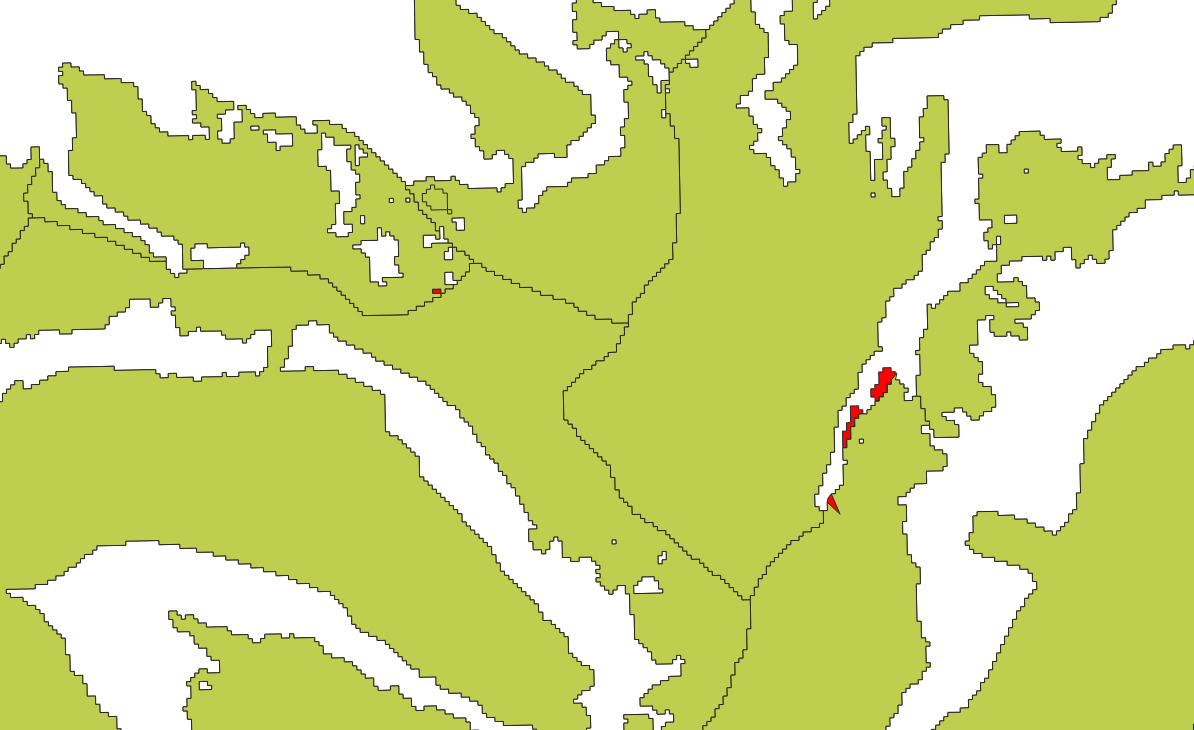